In [393]:
import pandas as pd 
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import shap
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error, classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score,precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor, XGBClassifier
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from scipy.stats import randint, uniform, zscore, stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import TargetEncoder
from sklearn import linear_model
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import statsmodels.api as sm
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
import joblib

In [394]:
df = pd.read_csv("/workspaces/carlossuesc95-intro-ml/data/raw/internal-link tree.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


### Eliminamos "Insulin" por tener demasiados valores faltantes 

In [395]:
#Susttuimos ceros por NaN
df.drop('Insulin', axis=1, inplace=True)
df_cop = df.copy()
vars_cero = ['BloodPressure', 'BMI', 'Glucose']
df_cop[vars_cero] = df_cop[vars_cero].replace(0, np.nan)

In [396]:
df_cop.isnull().sum()   

Pregnancies                  0
Glucose                      5
BloodPressure               35
SkinThickness                0
BMI                         11
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64

## Train Test Split 

In [397]:
X = df_cop.drop('Outcome',axis=1)
y = df_cop['Outcome']

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Imputacion

In [399]:
imputer = MissForest()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_train_imp

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 120.56it/s]


,Pregnancies,SkinThickness,Age,DiabetesPedigreeFunction,Glucose,BMI,BloodPressure
60,2,0,21,0.30,84.00,27.05,68.91
618,9,24,50,1.28,112.00,28.20,82.00
346,1,19,22,0.65,139.00,28.70,46.00
294,0,0,65,0.25,161.00,21.90,50.00
231,6,37,46,0.24,134.00,46.20,80.00
...,...,...,...,...,...,...,...
71,5,35,26,0.41,139.00,28.60,64.00
106,1,0,27,0.21,96.00,22.40,122.00
270,10,37,38,1.14,101.00,45.60,86.00
435,0,0,29,0.20,141.00,42.40,74.22


## Seleccion de caracteristicas

### metodo 1

In [400]:
model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1).fit(X_train_imp,y_train)
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

#Convertir a dataframe
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

#importancia acumulada
df_rf_imp['rf_importance_accum'] = df_rf_imp['rf_importance'].cumsum()

df_rf_imp

,feature,rf_importance,rf_importance_accum
4,BMI,27.79,27.79
5,DiabetesPedigreeFunction,17.69,45.49
2,BloodPressure,15.10,60.58
3,SkinThickness,13.48,74.07
6,Age,10.13,84.19
0,Pregnancies,8.13,92.32
1,Glucose,7.68,100.00


### metodo 2

In [401]:
#XGBClassifier

#crear conjunto de val
X_train1, X_val, y_train1, y_val = train_test_split(X_train_imp,y_train, test_size=0.2,random_state=42)

#ajustar modelo

model_xgb = XGBClassifier(objective='binary:logistic',random_state=42).fit(X_train1,y_train1)

#### 10 permutaciones por caracteristica

In [402]:
perm = permutation_importance(model_xgb,X_val,y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='recall')
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
4,BMI,24.05
2,BloodPressure,6.90
3,SkinThickness,2.62
5,DiabetesPedigreeFunction,2.14
1,Glucose,1.90
0,Pregnancies,0.48
6,Age,-2.38


### metodo 3

In [403]:

#METODO 3: usar SHAP

model_lgbm = lgb.LGBMClassifier(random_state=42,n_jobs=-1).fit(X_train1,y_train1)

explainer = shap.Explainer(model_lgbm,X_val)
shap_vals = explainer(X_val,check_additivity=False).values

imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
4,Glucose,29.09
2,Age,19.24
5,BMI,18.76
3,DiabetesPedigreeFunction,13.54
6,BloodPressure,7.22
1,SkinThickness,6.31
0,Pregnancies,5.84


In [404]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_accum,perm_imp,shap_imp
1,BMI,27.79,27.79,24.05,18.76
3,DiabetesPedigreeFunction,17.69,45.49,2.14,13.54
2,BloodPressure,15.10,60.58,6.90,7.22
6,SkinThickness,13.48,74.07,2.62,6.31
0,Age,10.13,84.19,-2.38,19.24
5,Pregnancies,8.13,92.32,0.48,5.84
4,Glucose,7.68,100.00,1.90,29.09


In [405]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp'].abs()>=0.1)&(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_accum,perm_imp,shap_imp
1,BMI,27.79,27.79,24.05,18.76
3,DiabetesPedigreeFunction,17.69,45.49,2.14,13.54
2,BloodPressure,15.10,60.58,6.90,7.22
6,SkinThickness,13.48,74.07,2.62,6.31
0,Age,10.13,84.19,-2.38,19.24
5,Pregnancies,8.13,92.32,0.48,5.84
4,Glucose,7.68,100.00,1.90,29.09


In [406]:
features = df_filt['feature']
features

1                         BMI
3    DiabetesPedigreeFunction
2               BloodPressure
6               SkinThickness
0                         Age
5                 Pregnancies
4                     Glucose
Name: feature, dtype: object

### Vif

In [407]:
X_train[features].isnull().sum()

BMI                          7
DiabetesPedigreeFunction     0
BloodPressure               24
SkinThickness                0
Age                          0
Pregnancies                  0
Glucose                      5
dtype: int64

In [408]:
X_vif = add_constant(X_train_imp[features])

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)
vif = vif.drop("const")
vif

BMI                        1.35
DiabetesPedigreeFunction   1.06
BloodPressure              1.23
SkinThickness              1.24
Age                        1.66
Pregnancies                1.44
Glucose                    1.17
dtype: float64

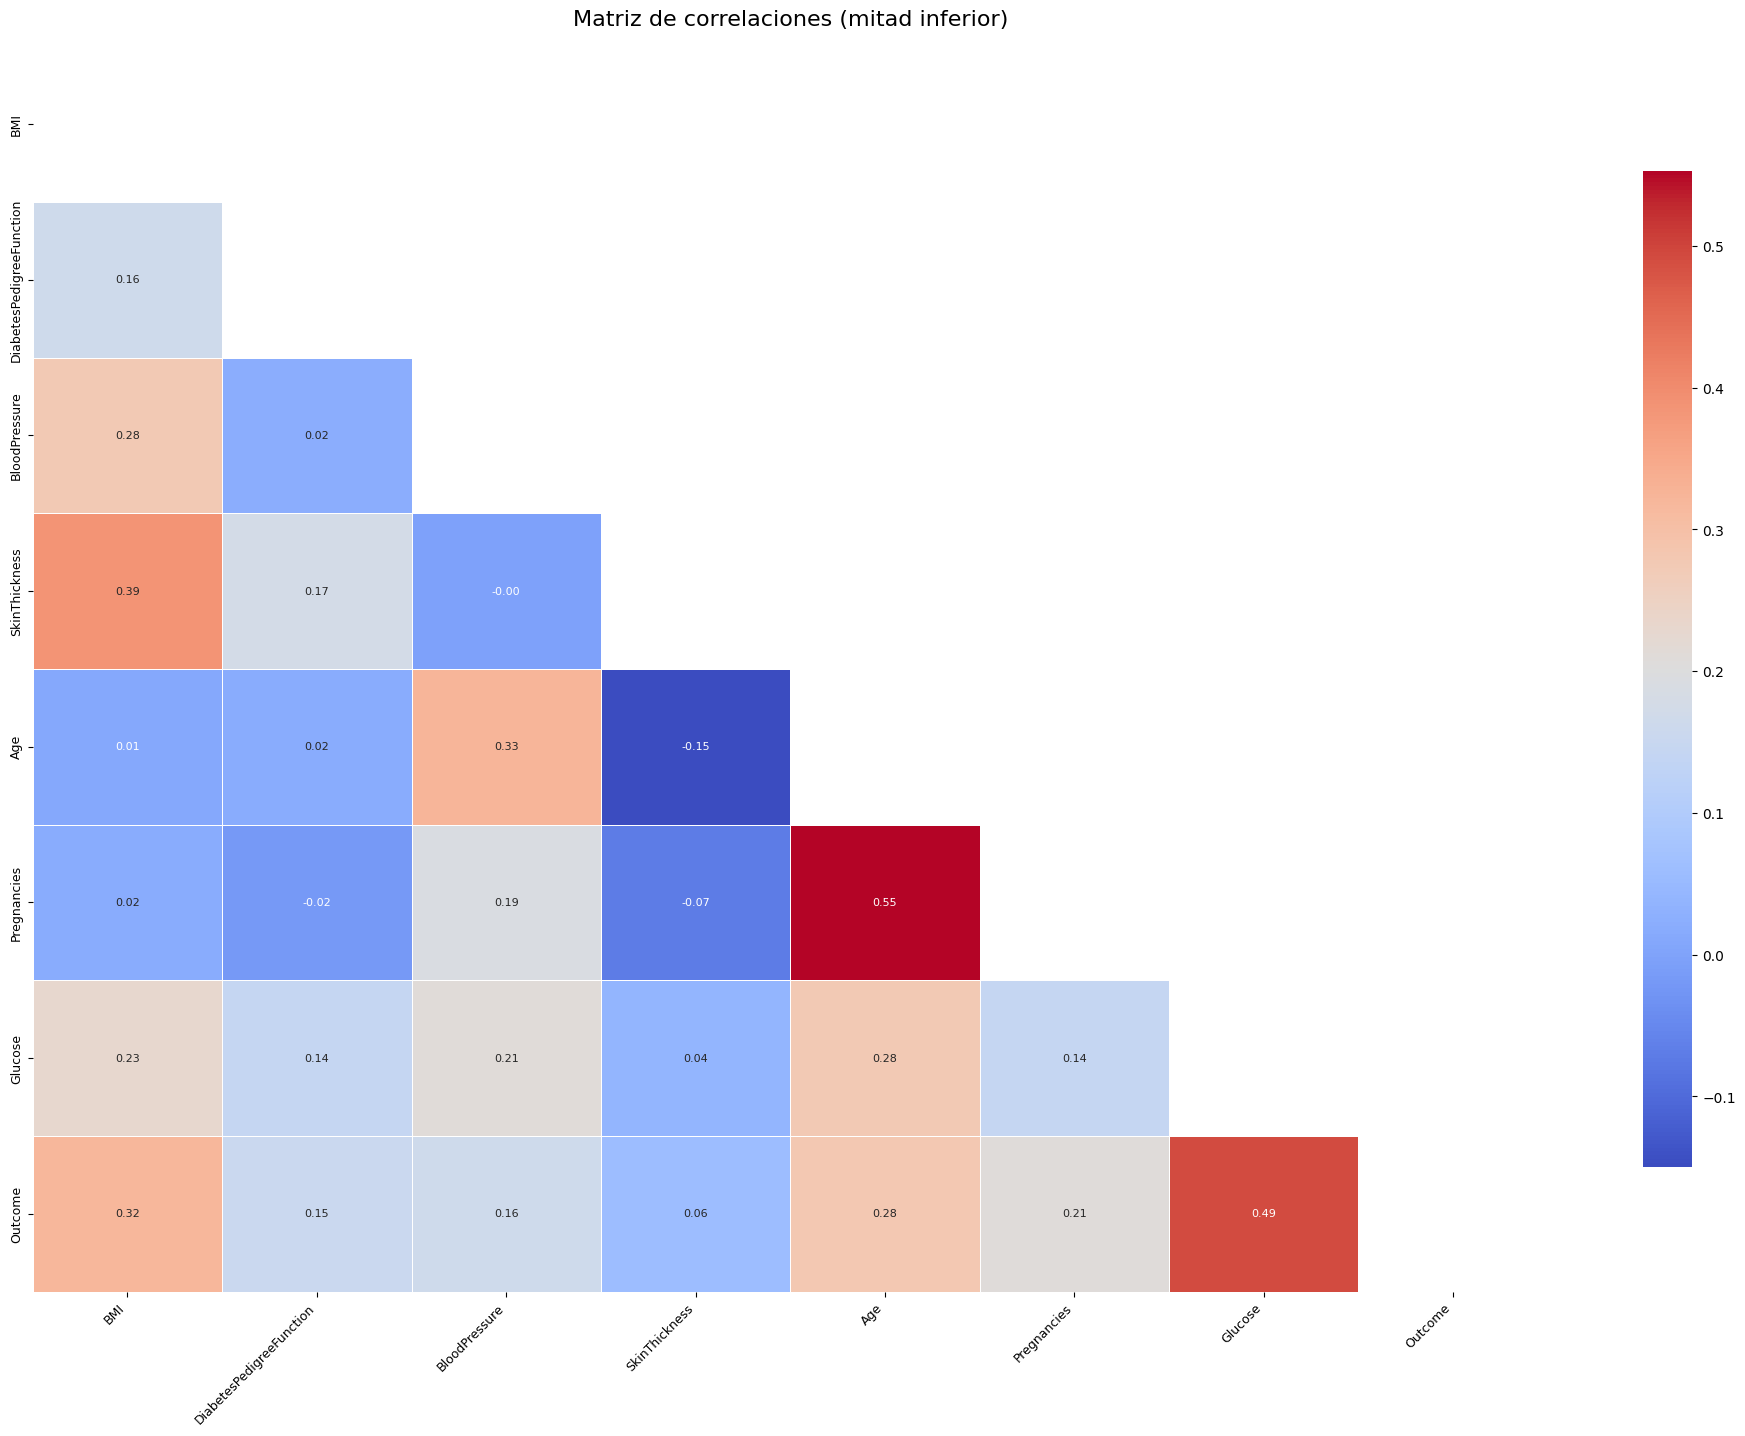

In [409]:
X_copy = X_train[features].copy()
X_copy['Outcome'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

### Cross Validation

In [410]:
# Versión 1: Realizar cross_validation con todas las características que son candidatas
cv_results1 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1, class_weight='balanced'),X_train_imp[features], y_train, cv=3, scoring='recall')

In [411]:
cv_results1.mean()

np.float64(0.5727699530516431)

In [412]:
#V2

cv_results2 = cross_val_score(RandomForestClassifier(random_state=42,n_jobs=-1,class_weight='balanced'),X_train_imp,y_train,cv=3,scoring='recall')
print(cv_results2)

[0.6056338  0.57746479 0.52112676]


In [413]:
cv_results2.mean()

np.float64(0.568075117370892)

In [414]:
X_train_sel = X_train_imp[features]
X_test_sel = X_test_imp[features]

## RF

#### Random Forest Classifier

In [415]:

random_forest = RandomForestClassifier(n_estimators=15,max_depth=2,min_samples_leaf=20,random_state=42)
random_forest.fit(X_train_sel,y_train)

#V1: evaluacion del modelo en entrenamiento y prueba
train_pred = random_forest.predict(X_train_sel)
test_pred= random_forest.predict(X_test_sel)

#### Decision Tree Classifier

In [416]:
tree_decision = DecisionTreeClassifier(criterion='gini',max_depth=None, max_features=X_train_sel.shape[1]//2, min_samples_leaf=1,random_state=42)
tree_decision.fit(X_train_sel, y_train)

train_pred2 = tree_decision.predict(X_train_sel)
test_pred2= tree_decision.predict(X_test_sel)

In [417]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    #train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    #test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    #diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall,],[test_accuracy, test_f1, test_auc, test_precision, test_recall],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall,]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [418]:
get_metrics(y_train,y_test,train_pred,test_pred)

,Accuracy,F1,AUC,Precision,Recall
Train,0.77,0.56,0.69,0.85,0.41
Test,0.78,0.63,0.72,0.78,0.53
Diferencia,-0.01,-0.08,-0.04,0.06,-0.11


In [419]:
get_metrics(y_train,y_test,train_pred2,test_pred2)

,Accuracy,F1,AUC,Precision,Recall
Train,1.00,1.00,1.00,1.00,1.00
Test,0.70,0.60,0.68,0.58,0.62
Diferencia,0.30,0.40,0.32,0.42,0.38


### Seguimos el analisis con RandomForest 

### matriz pred-randomforest

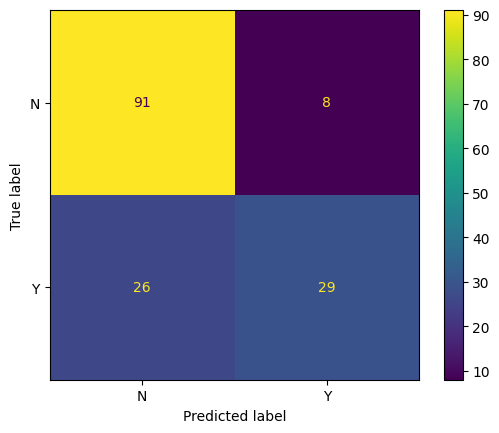

In [420]:
cm = confusion_matrix(y_test, test_pred)
cm

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'Y'])
disp.plot()

### Optimizacion RandomForest

In [421]:
model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Grid de hiperparámetros
param_grid = {
    'criterion': ['gini'],
    'max_depth': [5, 8, None],
    'min_samples_leaf': [10, 20],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 10]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Ajuste
grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model_classifier = grid_search.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.5s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.5s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.4s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=

### Metricas Modelo mejorado

In [422]:
y_train_pred_opt = best_model_classifier.predict(X_train)
y_test_pred_opt = best_model_classifier.predict(X_test)
get_metrics(y_train,y_test,y_train_pred_opt,y_test_pred_opt)

,Accuracy,F1,AUC,Precision,Recall
Train,0.85,0.77,0.82,0.83,0.72
Test,0.75,0.65,0.73,0.66,0.64
Diferencia,0.10,0.12,0.09,0.17,0.09


### Haciendo la busqueda de hiperparametros se ve una mejora significativa en la mejora de Train, en todas las metricas menos en la precision 

In [423]:

max_depth_values = [1, 2, 3, 5, 10]
accuracies_depth = []

for depth in max_depth_values:
    rf = RandomForestClassifier(
        n_estimators=5,
        max_depth=depth,
        min_samples_leaf=20,                 
        max_features=X_train_imp.shape[1] // 2,
        random_state=42,
    )
    rf.fit(X_train_imp, y_train)
    y_pred = rf.predict(X_test_imp)
    acc = accuracy_score(y_test, y_pred)
    accuracies_depth.append(acc)
    

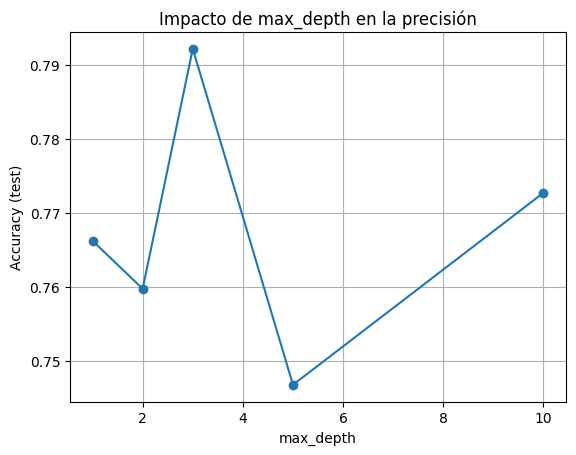

In [424]:
plt.figure()
plt.plot(max_depth_values, accuracies_depth, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Accuracy (test)")
plt.title("Impacto de max_depth en la precisión")
plt.grid(True)
plt.show()

In [425]:

min_samples_leaf_values = [1, 5, 10, 20, 50]
accuracies_leaf = []

for leaf in min_samples_leaf_values:
    rf = RandomForestClassifier(
        n_estimators=5,
        max_depth=2,                         # FIJO
        min_samples_leaf=leaf,
        max_features=X_train.shape[1] // 2,
        random_state=42,
    )
    
    rf.fit(X_train_imp, y_train)
    y_pred = rf.predict(X_test_imp)
    acc = accuracy_score(y_test, y_pred)
    accuracies_leaf.append(acc)

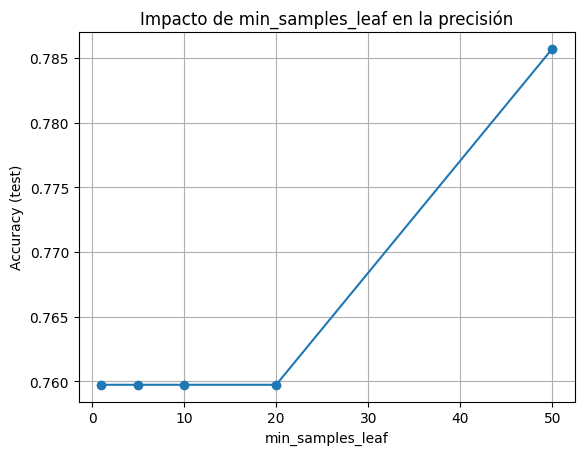

In [426]:
plt.figure()
plt.plot(min_samples_leaf_values, accuracies_leaf, marker='o')
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy (test)")
plt.title("Impacto de min_samples_leaf en la precisión")
plt.grid(True)
plt.show()

### Despues de varias pruebas para mejorar el accuracy del modelo simple, he podido observar que con un n_estimators de 15 es donde nos sale un accuracy muy parecido entre train y test.
### Cosa que no pasa en el complejo a tener 100 estimadores ,tiene overfitting 

### Guardamos el modelo

In [427]:
joblib.dump(best_model_classifier,'random_fts_diabetes.pkl')

['random_fts_diabetes.pkl']